# Energy Portfolio Management for Sustainable Campus


Add problem description...

In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import utils
from datetime import datetime, timedelta

## Parameters

In [2]:
T = 96                                   # Number of periods
nScenarios = 5                           # Number of scenarios

# Contract prices
P  = np.array([150, 360, 200, 50]) # Contract prices [$\MW]
pF = 18/4                          # option excercise fee [$\MW(h\4)]

Cw = 20                            # Maximum wind generator capacity
Cg = 10                            # Maximum gas generator capacity
Cs = 1                             # Maximum solar generator capacity

t = np.array(range(T))             # Periods
h = t//4                           # Hour of the day
peakHour = ((h>=8)*(h<18))         # Indicator for peak hour (8AM-6PM)

pr = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) # Probability of each scenario

We load the demand and generation data from each scenario

In [3]:
scenarios = ["scenarios/Scenario1.csv","scenarios/Scenario2.csv",
            "scenarios/Scenario3.csv","scenarios/Scenario4.csv",
            "scenarios/Scenario5.csv"]
T = 96                                   # Number of periods
nScenarios = 5                           # Number of scenarios
demand = np.empty([T,nScenarios])
windPF = np.empty([T,nScenarios])
solarPF = np.empty([T,nScenarios])
rtPrice = np.empty([T,nScenarios])

for i in range(nScenarios):
    scenario = pd.read_csv(scenarios[i])
    demand[:,i] = scenario.iloc[:T,1]/1000
    windPF[:,i] = scenario.iloc[:T,2]
    solarPF[:,i] = scenario.iloc[:T,3]
    rtPrice[:,i] = scenario.iloc[:T,4]/4

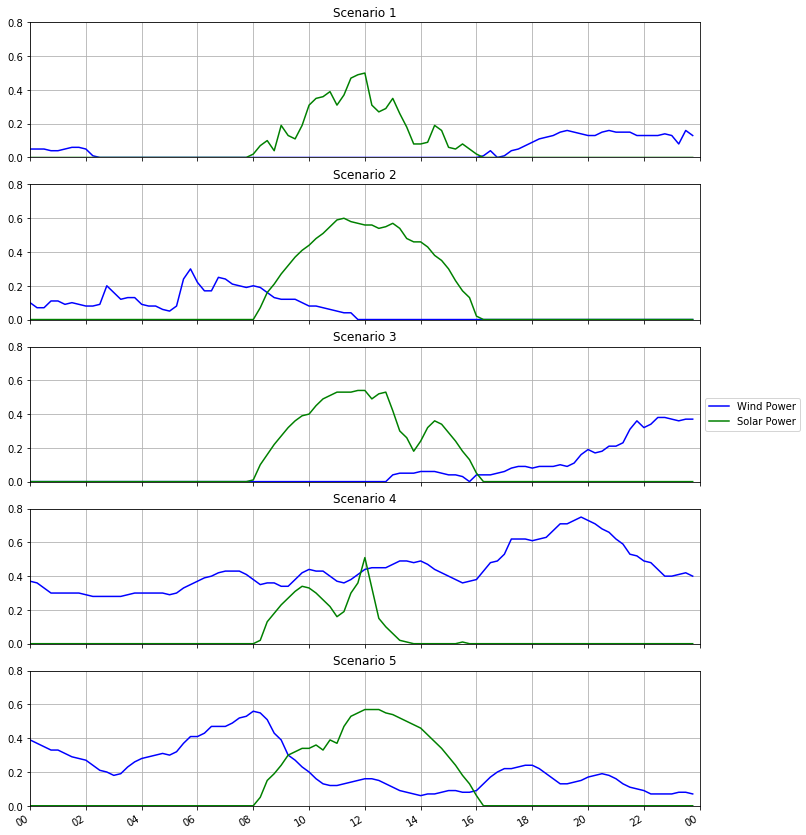

In [4]:
utils.PlotPowerFactors(windPF,solarPF,T)

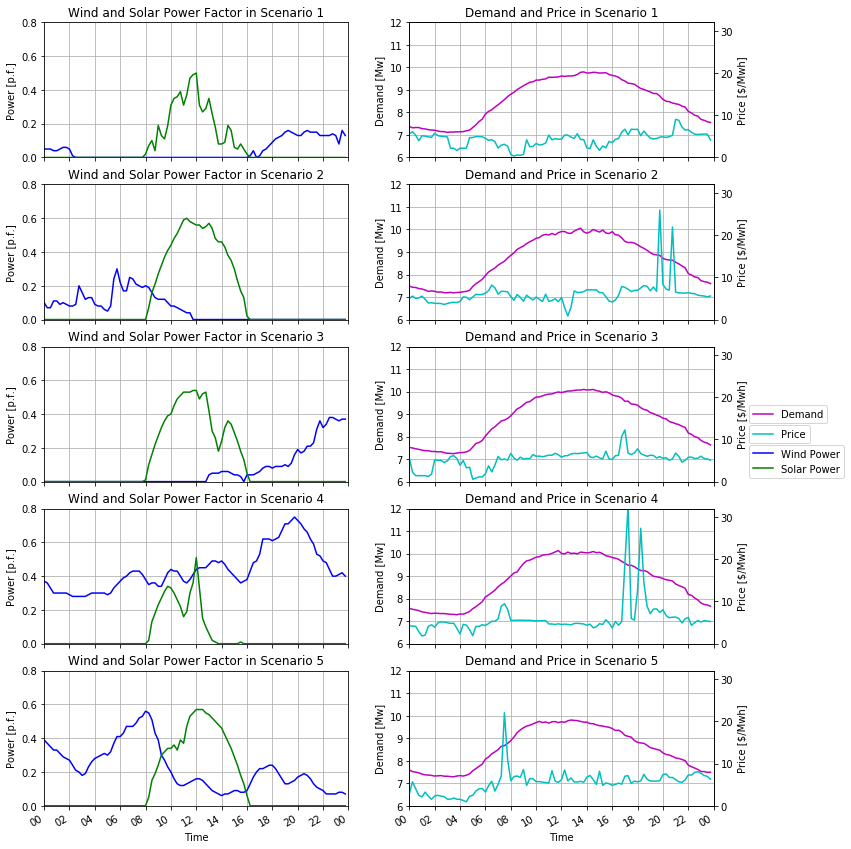

In [5]:
utils.PlotAllVars(windPF,solarPF,demand,rtPrice,T)

## Decision variables

The decision variables are of two types:
* $y$: The amount of capacity to buy from each contract. Specifically, $y=(y_0,y_1,y_2,y_3)$, where $y_0$ is wind generation, $y_1$ is base load service, $y_2$ is peak load service and $y_3$ is load following sercice.
* $x$: The power to buy/sold in the operation day. $x$ specifies values for each scenario and each period. Specifically, let $x^o_{\omega t}$ be the amount of power to but from the option call contract in scenario $\omega$ and period $t$, and let $x_{\omega t}^m$ be the amount of power to buy/sell in the spot market in order to balance demand and generation. We stack these variables in vectors as $$x^o = (\underbrace{x^o_{11},\dots,x^o_{1t},\dots,x^o_{1T},}_{scenario \,\,1}\dots,\underbrace{x^o_{51},\dots,x^o_{5t},\dots,x^o_{5T}}_{scenario\,\, 5})$$ and
$$x^m = (\underbrace{x^o_{11},\dots,x^m_{1t},\dots,x^m_{1T},}_{scenario \,\,1}\dots,\underbrace{x^m_{51},\dots,x^m_{5t},\dots,x^m_{5T}}_{scenario\,\, 5}).$$ And then we stack all the valiable into one vector: $$x = (x^o,x^m)^t.$$

In [6]:
x = cp.Variable(2*T*nScenarios)
y = cp.Variable(4,nonneg = True)

## Constraints and Objective function

We will write the problem in matrix form as:
$$\min_{x,y} P^ty + Q^tx,\,\,\mbox{s.t.}\, Ax\leq By+C,\, Dy\leq E $$

### Objective function
The vector $Q$ contains two sub-vectors $Q=(Q_1,Q_2)$ so that $Q^tx=Q_1^tx^o+Q_2^tx^m$.

We define $$Q_1 = pF(\underbrace{Pr_{1},\dots,Pr_1}_{T\,\, times},\dots,\underbrace{Pr_{5},\dots,Pr_5}_{T\,\, times}),$$
where $pF$ is the option exercise fee and $Pr_{\omega}$ is the probability of scenario $\omega$. For $Q_2$ we have
$$Q_2 = (Pr_{1}p_{11},\dots,Pr_1p_{1T},\dots,Pr_{5}p_{51},\dots,Pr_5p_{5T}),$$
where $p_{\omega t}$ is the real time price in scenario $\omega$ at time $t$.

The vector $P$ contains the capacity prices for each contract.

### Constraints

The matrices A,B and C are defined by three blocks: $A = [A_1^t,A_2^t,A_3^t]^t$, $B = [B_1^t,B_2^t,B_3^t]^t$ and $C = [C_1^t,C_2^t,C_3^t]^t$.

The first block codifies the inequality constraint $$x^o_{\omega t}\leq y_3,$$
so we define $$A_1 = [I_{(5T,5T)}, 0_{(5T,5T)}],$$
$$B_1 = [0_{(5T,3)}, 1_{(5T,1)}],\,\, C_1 = 0_{(5T,1)}$$
where $I_{(5T,5T)}$ is the identity matrix of dimension $5T$ (number of scenarios times the number of periods), and $0_{(n1,n2)},1_{(n1,n2)}$ are matrices of zeros and ones respectively. 

The second block codifies the nonnegativity constraint
$$x^o_{\omega t}\geq 0,$$
so, 
$$A_2 = -[I_{(5T,5T)}, 0_{(5T,5T)}],$$
$$B_2 = 0_{(5T,4)},\,\, C_1 = 0_{(5T,1)}$$

And the third block codifies the market balance constraint
$$demand_{\omega t} \leq x^o_{\omega t}+ x^m_{\omega t} + \underbrace{y_0f^w_{\omega t}}_{wind\,power}+\underbrace{y_1}_{base\,power}
+\underbrace{y_2\delta_{t}}_{peak\,power}+\underbrace{C^sf^s_{\omega t}}_{solar\,power},$$
where $f^w_{\omega t}$, $f^s_{\omega t}$ are the wind and solar power factors, $C^s$ is solar capacity (1 MW), the peak hour indicator $\delta_t$ is 1 if $t$ is between 8AM and 6PM.
We define 
$$A_3 = -[I_{(5T,5T)}, I_{(5T,5T)}],$$
$$B_3 = [f^w ,1_{(5T,1)},\Delta,0],\,\, C_3 = C^sf^s-Demand$$

where $f^w$, $f^s$, $Demand$ and $\Delta$ are the vectors of power factors, demand and peak hour indicators in each scenario and period pair.

In [7]:
# Matrices Q, A, B and C
Q = np.empty([2*T*nScenarios,1])
A = np.zeros([3*T*nScenarios,2*T*nScenarios])
B = np.zeros([3*T*nScenarios,4])
C = np.zeros([3*T*nScenarios,1])

# First set of constraints x^o_{wt} \leq y_4
A[:(T*nScenarios),:(T*nScenarios)] = np.identity(T*nScenarios)
B[:(T*nScenarios),3] = 1 

# Second set of constraints x^o_{wt} \geq 0
A[(T*nScenarios):(2*T*nScenarios),
  :(T*nScenarios)] = -np.identity(T*nScenarios)

for i in range(nScenarios):
    
    # Costs in bjective function Q1: option fee, Q2: market price
    Q1 = np.ones((T,1))*pr[i]*pF
    Q2 = rtPrice[:,i]*pr[i]
    Q[(T*i):(T*(i+1)),:] = Q1
    Q[(T*nScenarios+T*i):(T*nScenarios+T*(i+1)),:] = Q2.reshape((T, 1))
    
    # Third set of constraints 
    # -x^o_{wt}-x^m_{wt} \leq -demand + solar + wind + base_load + peak_load
    A[(2*T*nScenarios+T*i):(2*T*nScenarios+T*(i+1)),
     (T*i):(T*(i+1))] = - np.identity(T) 
    
    A[(2*T*nScenarios+T*i):(2*T*nScenarios+T*(i+1)),
     (T*nScenarios+T*i):(T*nScenarios+T*(i+1))] = - np.identity(T) 
    
    B[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),0] = (windPF[:,i])
    
    B[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),1] = np.ones(T)
    
    B[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),2] = peakHour
    
    C[(2*T*nScenarios+T*i):
      (2*T*nScenarios+T*(i+1)),0] =  Cs*solarPF[:,i]-demand[:,i]
    

The matrices $D$ and $E$ codify two constraints:
* Gas generator capacity $$y_1+y_2+y_3\leq C^g$$
* Wind generator capacity $$y_0\leq C^w$$

In [8]:
# Matrices D and E
D = np.array([[0,1,1,1],[1,0,0,0]])
E = np.array([[Cg],[Cw]])

The objective function minimizes costs

In [9]:
obj = cp.Minimize(P@y + np.transpose(Q)@x)

We add the constraints

In [10]:
# Initialize an empty constraint set
con_set_1 = [] 

con_set_1.append(A@x <= B@y + C.flatten())
con_set_1.append(D@y <= E.flatten())

Now we solve the optimization problem

In [11]:
prob1 = cp.Problem(obj, con_set_1)
prob1.solve(solver = "GUROBI")
prob1.solve();

Academic license - for non-commercial use only - expires 2022-01-02
Using license file C:\Users\Rob\gurobi.lic


In [12]:
print("\n The optimal wind capacity is: %.1f" % (y[0].value))
print("\n The optimal base capacity from the gas generator is: %.1f" % (y[1].value))
print("\n The optimal peak capacity from the gas generator is: %.1f" % (y[2].value))
print("\n The optimal load following capacity from the gas generator is: %.1f" % (y[3].value))


 The optimal wind capacity is: 0.0

 The optimal base capacity from the gas generator is: 10.0

 The optimal peak capacity from the gas generator is: 0.0

 The optimal load following capacity from the gas generator is: 0.0


In [13]:
data_all = utils.GetAllVariables(x,y,demand,windPF,solarPF,Cs,nScenarios,peakHour,rtPrice,T)

data_all.to_csv("outputs/Results_min_exp_cost.csv")

data_all.head()

,Demand_s1,GasBase_s1,GasOption_s1,GasPeak_s1,SolarPower_s1,SpotMarket_s1,WindPower_s1,Demand_s2,GasBase_s2,GasOption_s2,...,SolarPower_s4,SpotMarket_s4,WindPower_s4,Demand_s5,GasBase_s5,GasOption_s5,GasPeak_s5,SolarPower_s5,SpotMarket_s5,WindPower_s5
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,7.37568,10.0,5.017297e-11,0.0,0.0,-2.62432,1.999354e-13,7.48512,10.0,4.074669e-11,...,0.0,-2.42848,1.479522e-12,7.58880,10.0,1.575519e-13,0.0,0.0,-2.41120,1.559496e-12
2021-01-01 00:15:00,7.31808,10.0,5.365484e-11,0.0,0.0,-2.68192,1.999354e-13,7.43328,10.0,4.966558e-11,...,0.0,-2.47168,1.439535e-12,7.51968,10.0,5.083568e-11,0.0,0.0,-2.48032,1.479522e-12
2021-01-01 00:30:00,7.32960,10.0,4.591906e-11,0.0,0.0,-2.67040,1.999354e-13,7.42464,10.0,4.041417e-11,...,0.0,-2.49760,1.319573e-12,7.49376,10.0,1.413955e-11,0.0,0.0,-2.50624,1.399548e-12
2021-01-01 00:45:00,7.32960,10.0,1.211435e-11,0.0,0.0,-2.67040,1.599483e-13,7.37568,10.0,4.358924e-11,...,0.0,-2.53216,1.199612e-12,7.46208,10.0,-7.031573e-13,0.0,0.0,-2.53792,1.319573e-12
2021-01-01 01:00:00,7.28064,10.0,4.344845e-11,0.0,0.0,-2.71936,1.599483e-13,7.35552,10.0,4.944149e-11,...,0.0,-2.58400,1.199612e-12,7.40736,10.0,-7.976264e-13,0.0,0.0,-2.59264,1.319573e-12


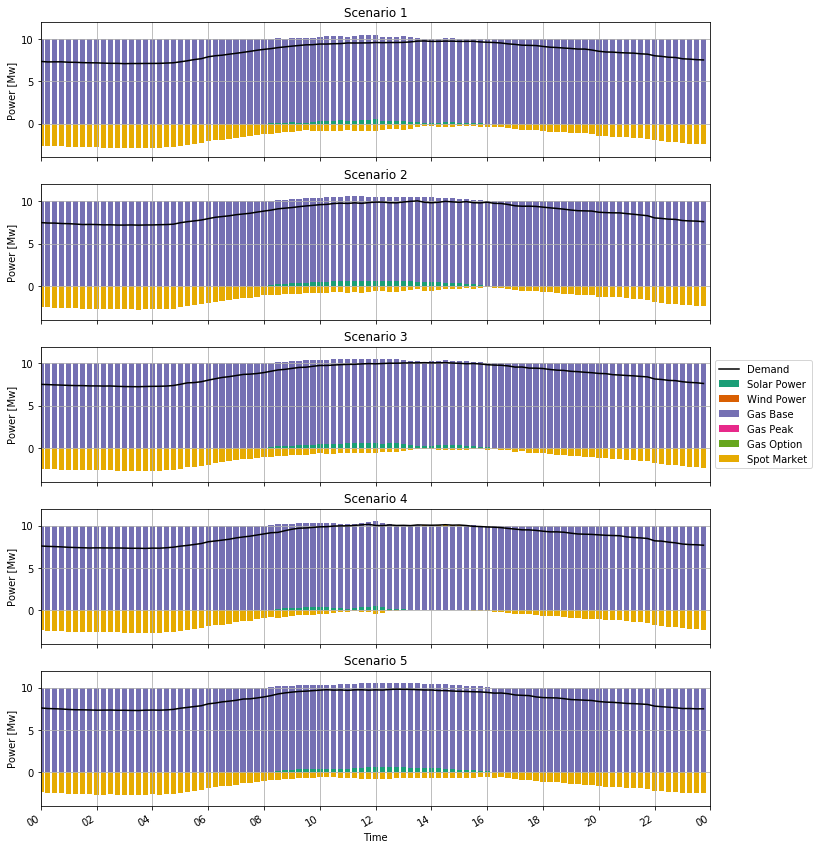

In [14]:
utils.PlotEnergyMix(x,y,demand,windPF,solarPF,Cs,nScenarios,peakHour,rtPrice,T,"outputs/min_exp_cost")

In [15]:
obj.value

2920.0385124844297